In [16]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "./cifar-10-100n/")

import os
import torch
from PIL import Image as im
import pandas as pd
import numpy as np
from autogluon.vision import ImagePredictor, ImageDataset
import pickle
import datetime
from pathlib import Path
import cleanlab

from data.datasets import input_dataset
from cross_validation_autogluon import cross_val_predict_autogluon_image_dataset

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Read data

In [17]:
# get labels
noise_file = torch.load('./cifar-10-100n/data/CIFAR-10_human.pt')
clean_label = noise_file['clean_label']
worst_label = noise_file['worse_label']
aggre_label = noise_file['aggre_label']
random_label1 = noise_file['random_label1']
random_label2 = noise_file['random_label2']
random_label3 = noise_file['random_label3']

In [18]:
# get data
dataset = "cifar10"
noise_type = "worse_label"
noise_path = "./cifar-10-100n/data/CIFAR-10_human.pt"
is_human = True

train_dataset, test_dataset, num_classes, num_training_samples = \
    input_dataset(dataset, noise_type, noise_path, is_human)

Files already downloaded and verified
Loaded worse_label from ./cifar-10-100n/data/CIFAR-10_human.pt.
The overall noise rate is 0.40208
noisy labels loaded from ./cifar-10-100n/data/CIFAR-10_human.pt
The noisy data ratio in each class is [0.10618 0.12106 0.10684 0.09346 0.0808  0.11336 0.08406 0.10546 0.09258
 0.0962 ]
over all noise rate is  0.40208


In [4]:
print(f"Accuracy of noisy labels vs true labels: {(worst_label == clean_label).mean()}")

Accuracy of noisy labels vs true labels: 0.59792


In [5]:
# classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Manually inspect some images

Datapoint index: 19880
  Noisy Label: 7, horse
  True Label: 1, automobile


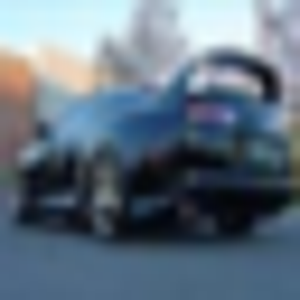

In [15]:
# check out some images
idx = 19880

# pick random image to inspect
# idx = np.random.randint(0, train_dataset.train_data.shape[0])

X = train_dataset.train_data[idx]
noisy_label = train_dataset.train_noisy_labels[idx]
true_label = train_dataset.train_labels[idx]

print(f"Datapoint index: {idx}")
print(f"  Noisy Label: {noisy_label}, {classes[noisy_label]}")
print(f"  True Label: {true_label}, {classes[true_label]}")

newsize = (300, 300) # zoom in

im.fromarray(X).resize(newsize)

Datapoints to inspect further:

Datapoints (index) where the true label is wrong
  14023 (true label is airplane but looks like a bird)

## Save images to folder

AutoGluon image models require the data to be image files in a folder

We'll save the images as PNG files in a single folder and save their file paths in a list

In [ ]:
%%time

# create folder
SAVE_PATH = "./cifar-10n-png/train/"
os.makedirs(SAVE_PATH)

# save images to folder

image_file_paths = [] # list of image file paths

for i, data in enumerate(train_dataset.train_data):
    
    # convert data to image object
    image = im.fromarray(data) 

    # path to image PNG file
    png_file = f"{SAVE_PATH}image_id_{i}.png"
    
    # print the number of images saved
    print(f"Images saved: {i + 1}", end="\r")
    
    # append file to list of file paths
    image_file_paths.append(png_file)
    
    # save image as PNG
    image.save(png_file)

## Create DataFrame to use as input for AutoGluon Image predictor

In [ ]:
# Note: AutoGluon requires the column names to be "image" and "label"
df_train = pd.DataFrame({
    "image": image_file_paths,
    "label": train_dataset.train_noisy_labels, # noisy labels
    "true_label": train_dataset.train_labels # true labels
})

In [ ]:
df_train.reset_index().to_csv("cifar-10n-dataset-noise-type-worse.csv", index=False)

In [ ]:
assert (clean_label == df_train.true_label.values).all()

# Optional: copy the images to a faster drive (e.g. M.2 SSD) which will speedup training

In [ ]:
!cp -r ./cifar-10n-png/ /Data/cifar-10n-png/

In [ ]:
# !ls /Data/cifar-10n-png

In [ ]:
# add prefix to file path if we moved it to another drive
prefix = "/Data/"
df_train["image"] = df_train.image.map(lambda f: str(Path(prefix + f)))
df_train.head()

In [ ]:
!ls /Data

## Run cross-validation with AutoGluon

In [ ]:
%%time

# generate cross-validated predicted probabilities for various models so we can use them for ensemble scoring methods
models = [
    "resnet18",
    "resnet50d",
    "efficientnet_b1",
    "twins_pcpvt_base",
    "swin_base_patch4_window7_224"
]

epochs = 100
holdout_frac = 0.2
n_splits = 5

# run cross-validation for each model
for model in models:
    
    print("----")
    print(f"Running cross-validation for model: {model}")

    MODEL_PARAMS = {
        "model": model,
        "epochs": epochs,
        "holdout_frac": holdout_frac
    }

    # results of cross-validation will be saved to pickle files for each model/fold
    _ = \
        cross_val_predict_autogluon_image_dataset(
            dataset=df_train, # train with NOISY LABELS
            out_folder=f"./cifar-10n-png_noise_type_worst_cv_{model}/", # save results of cross-validation in pickle files for each fold
            n_splits=n_splits,
            model_params=MODEL_PARAMS
        )